In [0]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
sc

SparkContext 

 Spark UI 

 
 Version 
 v2.4.5 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
spark = SparkSession.builder.appName('Final_exam_Mohanaditya_Karampudi').getOrCreate()

In [0]:
spdf = spark.read.csv("dbfs:/FileStore/tables/housing.csv", header=True, mode="DROPMALFORMED")
from pyspark.sql import functions as F
spdf = spdf.select([F.col(x).alias(x.lower()) for x in spdf.columns]) #convert to lower case

for col in spdf.columns:
  spdf = spdf.withColumnRenamed(col,col.replace(" ", "_")) #replace space with underscore in column name

In [0]:
from pyspark.sql import functions as sf 
spdf = spdf.withColumn('lat_long', 
                    sf.concat(sf.col('latitude'),sf.lit('_'), sf.col('longitude'))) #adding latitude and longitude to create a new column for answering

In [0]:
spdf.show(5) #Printing the top 5 rows of the spark dataframe

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-------------+
longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity| lat_long|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-------------+
 -122.23| 37.88| 41.0| 880.0| 129.0| 322.0| 126.0| 8.3252| 452600.0| NEAR BAY|37.88_-122.23|
 -122.22| 37.86| 21.0| 7099.0| 1106.0| 2401.0| 1138.0| 8.3014| 358500.0| NEAR BAY|37.86_-122.22|
 -122.24| 37.85| 52.0| 1467.0| 190.0| 496.0| 177.0| 7.2574| 352100.0| NEAR BAY|37.85_-122.24|
 -122.25| 37.85| 52.0| 1274.0| 235.0| 558.0| 219.0| 5.6431| 341300.0| NEAR BAY|37.85_-122.25|
 -122.25| 37.85| 52.0| 1627.0| 280.0| 565.0| 259.0| 3.8462| 342200.0| NEAR BAY|37.85_-122.25|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-------------+
only showing top 5 rows

In [0]:
print((spdf.count(), len(spdf.columns))) #dimensions of the data

(20640, 11)

In [0]:
#converting attributes to respective datatypes
spdf = spdf.withColumn("longitude", spdf.longitude.cast('float')).\
            withColumn('latitude', spdf.latitude.cast('float')).\
            withColumn('housing_median_age', spdf.housing_median_age.cast('int')).\
            withColumn('total_rooms', spdf.total_rooms.cast('int')).\
            withColumn('total_bedrooms', spdf.total_bedrooms.cast('int')).\
            withColumn('population', spdf.population.cast('int')).\
            withColumn('households', spdf.households.cast('int')).\
            withColumn('median_income', spdf.median_income.cast('float')).\
            withColumn('median_house_value', spdf.median_house_value.cast('int'))

In [0]:
spdf.dtypes #Verifying the data types of the df

Out[129]: [('longitude', 'float'),
 ('latitude', 'float'),
 ('housing_median_age', 'int'),
 ('total_rooms', 'int'),
 ('total_bedrooms', 'int'),
 ('population', 'int'),
 ('households', 'int'),
 ('median_income', 'float'),
 ('median_house_value', 'int'),
 ('ocean_proximity', 'string'),
 ('lat_long', 'string')]

In [0]:
#Printing the number of NA values in each column
from pyspark.sql.functions import col,sum
spdf.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in spdf.columns)).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+--------+
longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|lat_long|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+--------+
 0| 0| 0| 0| 207| 0| 0| 0| 0| 0| 0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+--------+

In [0]:
#Since our dataset is pretty huge with 20K rows, I have chosed to remove rows containig NULL values
spdf = spdf.filter(spdf.total_bedrooms. isNotNull()) #Dropping rows having NULL values in total_bedrooms
print("The number of rows after removing null values are: ", spdf.count())

The number of rows after removing null values are: 20433

In [0]:
#Sample
#there are three houses in latitude 37.85 and longitude -122.25. The sum of total rooms is 1274+1627+919=3820. 
#This code is to verify whether the spark code is working as expected..
spdf.where(spdf.lat_long == '37.85_-122.25').groupby(['lat_long']).sum('total_rooms').show()
# The code is working fine and can be executed for the whole dataframe


#The similar output can be achieved using aggregation function after grouping by latitude and longitude, this approach eliminates the creation of new column 
#But for this exam I went on creating lat_long attribute

+-------------+----------------+
 lat_long|sum(total_rooms)|
+-------------+----------------+
37.85_-122.25| 3820|
+-------------+----------------+

In [0]:
#Applying the code to whole dataframe to know the answer for the question
spdf.groupby(['lat_long','total_rooms']).sum('total_rooms').withColumnRenamed('sum(total_rooms)','total_rooms_in_district').sort(['total_rooms_in_district'], ascending=False).show(1)
#There is a single row which has 39320 rooms and the district is 38.43 and -121.44

+-------------+-----------+-----------------------+
 lat_long|total_rooms|total_rooms_in_district|
+-------------+-----------+-----------------------+
38.43_-121.44| 39320| 39320|
+-------------+-----------+-----------------------+
only showing top 1 row

In [0]:
spdf.where(spdf.lat_long == '38.43_-121.44').show() #There are just 5 bedrooms but 7460 people and has highest ratio of 1492

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-------------+
longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity| lat_long|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-------------+
 -121.44| 38.43| 3| 39320| 6210| 16305| 5358| 4.9516| 153700| INLAND|38.43_-121.44|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-------------+

In [0]:
spdf = spdf.withColumn("people_per_bedroom", (F.col("population") / F.col("total_bedrooms")))
spdf.groupby(['lat_long','people_per_bedroom']).sum('people_per_bedroom').withColumnRenamed('sum(people_per_bedroom)','people_per_bedroom_district').sort(['people_per_bedroom_district'], ascending=False).show(1)
#the District 38.32, -121.98 has highest ratio of people/bedroom. For 1 bedroom there are 1492 people

+-------------+------------------+---------------------------+
 lat_long|people_per_bedroom|people_per_bedroom_district|
+-------------+------------------+---------------------------+
38.32_-121.98| 1492.0| 1492.0|
+-------------+------------------+---------------------------+
only showing top 1 row

In [0]:
spdf.where(spdf.lat_long == '38.32_-121.98').show() #There are just 5 bedrooms but 7460 people and has highest ratio of 1492

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-------------+------------------+
longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity| lat_long|people_per_bedroom|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-------------+------------------+
 -121.98| 38.32| 45| 19| 5| 7460| 6| 10.2264| 137500| INLAND|38.32_-121.98| 1492.0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-------------+------------------+

In [0]:
print("The correlation between median_income and median house value is",spdf.stat.corr("median_income","median_house_value"))

The correlation between median_income and median house value is 0.6883554748351047

In [0]:
#  total rooms, total bedrooms, total population, total households, median income and distance to the ocean
# Import the required libraries
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler,StringIndexer
from pyspark.ml import Pipeline

In [0]:
# Use StringIndexer to convert the categorical columns to hold numerical data
ocean_proximity_indexer = StringIndexer(inputCol='ocean_proximity',outputCol='ocean_proximity_index',handleInvalid='keep')

In [0]:
#It is always a good parctice to standardize numerical attributes, since clustering can be skewed becasue of different ranges of each column
#standardizing them will help model create better clusters

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

# Iterating over columns to be scaled
for i in ["total_rooms","total_bedrooms",'population','households','median_income']:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_vect", outputCol=i+"_scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    spdf = pipeline.fit(spdf).transform(spdf).withColumn(i+"_scaled", unlist(i+"_scaled")).drop(i+"_vect")

In [0]:
# Vector assembler is used to create a vector of input features
assembler = VectorAssembler(inputCols=['total_rooms_scaled','total_bedrooms_scaled','population_scaled',
                                       'households_scaled','median_income_scaled','ocean_proximity_index'],
                            outputCol="features")

In [0]:
#Creating a pipeline and specifying all the process that should be done
pipe = Pipeline(stages=[ocean_proximity_indexer,assembler])

#A basic fit and transform of the pipeline on the dataset
final_data = pipe.fit(spdf).transform(spdf)

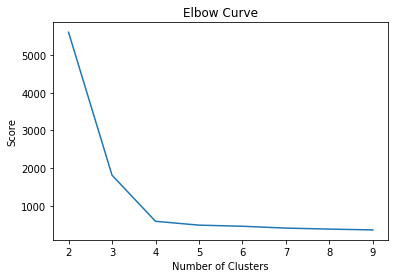

In [0]:
#I have executed the Kmeans model in pyspark (lines 8-10) The output of the error or cost from kmeans is stored as pandas dataframe
#with which I have plotted the elbow curve to know which number of cluster to consider

# Calculate cost and plot
import numpy as np
import pandas as pd
cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(final_data)
    cost[k] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [0]:
#From the above output we can see that with number of clusters as 4 or 5 the error is least 
#Creating a final clustering model with number of clusters as 4
kmeans_model = KMeans(k=4)
fit_model = kmeans_model.fit(final_data)
wssse = fit_model.computeCost(final_data)
print("The within set sum of squared error of the modle is {}".format(wssse))

The within set sum of squared error of the mode is 2361.057568598788

In [0]:
# # Make predictions
predictions = fit_model.transform(final_data)
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.6125748706278107

In [0]:
# Store the results in a dataframe
results = fit_model.transform(final_data)

results.select(['total_rooms_scaled','total_bedrooms_scaled','population_scaled',
                                       'households_scaled','median_income_scaled','ocean_proximity_index','prediction']).show(5)

+------------------+---------------------+-----------------+-----------------+--------------------+---------------------+----------+
total_rooms_scaled|total_bedrooms_scaled|population_scaled|households_scaled|median_income_scaled|ocean_proximity_index|prediction|
+------------------+---------------------+-----------------+-----------------+--------------------+---------------------+----------+
 0.022| 0.02| 0.009| 0.021| 0.54| 3.0| 1|
 0.181| 0.171| 0.067| 0.187| 0.538| 3.0| 1|
 0.037| 0.029| 0.014| 0.029| 0.466| 3.0| 1|
 0.032| 0.036| 0.016| 0.036| 0.355| 3.0| 1|
 0.041| 0.043| 0.016| 0.042| 0.231| 3.0| 1|
+------------------+---------------------+-----------------+-----------------+--------------------+---------------------+----------+
only showing top 5 rows

In [0]:
results.groupBy('prediction').count().orderBy('count',ascending=False).show() #printing the number of rows classifi

+----------+-----+
prediction|count|
+----------+-----+
 2| 9124|
 3| 6370|
 0| 2664|
 1| 2275|
+----------+-----+

In [0]:
#Take care and stay safe